<a href="https://colab.research.google.com/github/Saif-M-Dhrubo/AI-Lab/blob/master/AI_FinalASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Greek.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/German.txt', 'data/names/Italian.txt', 'data/names/Korean.txt', 'data/names/Irish.txt', 'data/names/Czech.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt']
Slusarski


In [59]:
!pip install paramiko

In [0]:
from __future__ import absolute_import

import os
import re

import numpy as np


def get_ethnicity_data(data_dir, params):
    is_ethnicity = params['ethnicity']

    for root, dir, files in os.walk(data_dir):
        unigram_set = []
        bigram_set = []
        trigram_set = []
        length_set = []
        labels = []

        unigram2idx = {}
        idx2unigram = {}
        bigram2idx = {}
        idx2bigram = {}
        trigram2idx = {}
        idx2trigram = {}
        country2idx = {}
        idx2country = {}
        country2ethnicity = {}
        name_max_len = 0

        train_set = []
        valid_set = []
        test_set = []

        for file_cnt, file_name in enumerate(sorted(files)):
            data = open(os.path.join(root, file_name))
            file_len = 0

            if file_name == '0_unigram_to_idx.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    unigram, index = line[:-1].split('\t')
                    unigram2idx[unigram] = int(index)
                    idx2unigram[int(index)] = unigram
            elif file_name == '1_bigram_to_idx.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    bigram, index = line[:-1].split('\t')
                    bigram2idx[bigram] = int(index)
                    idx2bigram[int(index)] = bigram
            elif file_name == '2_trigram_to_idx.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    trigram, index = line[:-1].split('\t')
                    trigram2idx[trigram] = int(index)
                    idx2trigram[int(index)] = trigram
            elif file_name == 'country_to_idx.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    country, index = line[:-1].split('\t')
                    if not is_ethnicity:
                        index = k  # Change to index when testing nationality
                    country2idx[country] = int(index)
                    idx2country[int(index)] = country
            elif file_name == 'country_to_ethnicity.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    country, eth1, eth2 = line[:-1].split('\t')
                    country2ethnicity[int(country)] = [int(eth1), int(eth2)]
            elif 'data_' in file_name:
                for k, line in enumerate(data):
                    name, nationality = line[:-1].split('\t')
                    name = re.sub(r'\ufeff', '', name)  # delete BOM

                    unigram_vector = [unigram2idx[c] if c in unigram2idx else 0 for c in name]
                    bigram_vector = [bigram2idx[c1 + c2] if (c1 + c2) in bigram2idx else 0
                                     for c1, c2 in zip(*[name[i:] for i in range(2)])]
                    trigram_vector = [trigram2idx[c1 + c2 + c3] if (c1 + c2 + c3) in trigram2idx else 0
                                      for c1, c2, c3 in zip(*[name[i:] for i in range(3)])]

                    # label vector
                    nationality = country2idx[nationality]
                    if is_ethnicity:
                        ethnicity = country2ethnicity[nationality][1]
                        if ethnicity < 0:
                            continue
                    name_length = len(name)

                    if name_max_len < len(name):
                        name_max_len = len(name)

                    unigram_set.append(unigram_vector)
                    bigram_set.append(bigram_vector)
                    trigram_set.append(trigram_vector)
                    length_set.append(name_length)
                    if is_ethnicity:
                        labels.append(ethnicity)
                    else:
                        labels.append(nationality)
                    file_len = k + 1

                if 'train_ch' in file_name:
                    train_set = [unigram_set, bigram_set, trigram_set, length_set, labels]
                elif 'val' in file_name:
                    valid_set = [unigram_set, bigram_set, trigram_set, length_set, labels]
                elif 'ijcai' in file_name:  # test
                    test_set = [unigram_set, bigram_set, trigram_set, length_set, labels]
                else:
                    assert True, 'not allowed file name %s' % file_name

                unigram_set = []
                bigram_set = []
                trigram_set = []
                length_set = []
                labels = []
            else:
                print('ignoring file', file_name)

            print('reading', file_name, 'of length', file_len)

    print('total data length:', len(train_set[0]), len(valid_set[0]), len(test_set[0]))
    print('shape of data:', np.array(train_set).shape, np.array(valid_set).shape, np.array(test_set).shape)
    print('name max length:', name_max_len)
    #print('Train Set : ', train_set)
    #print('Validation Set : ', valid_set)
    #print('Test Set : ', test_set)

    return (train_set, valid_set, test_set,
            [idx2unigram, unigram2idx, idx2country, country2ethnicity, idx2bigram, idx2trigram])


In [94]:
import gensim


data_dir = './data/raw'
params = {'ethnicity': False}
train_set, valid_set, test_set, dictionary = get_ethnicity_data(data_dir, params)
vec = 2
dic = 5

sentences = []
for sentence in train_set[vec][:]:
    char_seq = [dictionary[dic][c] for c in sentence]
    sentences.append(char_seq)
for sentence in valid_set[vec][:]:
    char_seq = [dictionary[dic][c] for c in sentence]
    sentences.append(char_seq)
for sentence in test_set[vec][:]:
    char_seq = [dictionary[dic][c] for c in sentence]
    sentences.append(char_seq)

model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=0, iter=100)

for alphabet in dictionary[dic].values():
    print('most similar to', alphabet, end=' is ')
    try:
        print(' '.join([(s) for s, _ in model.most_similar(positive=[alphabet], topn=10)]))
    except:
        print('no values', alphabet)

reading 0_unigram_to_idx.txt of length 82
reading 1_bigram_to_idx.txt of length 1876
reading 2_trigram_to_idx.txt of length 14767
reading country_to_ethnicity.txt of length 127
reading country_to_idx.txt of length 127
reading data_ijcai_authors of length 2408
reading data_raw_test of length 3543
reading data_raw_train of length 10633
reading data_raw_train_ch of length 10754
reading data_raw_valid of length 3545
total data length: 10754 3545 2408
shape of data: (5, 10754) (5, 3545) (5, 2408)
name max length: 47
most similar to   B is rui Min gra ask Shu Chi  Ya ebe  Di ngw
most similar to   H is no values   H
most similar to   M is e   Kem Nac J C ÖNE ARX OAK E.J Piu UJS
most similar to   R is n   b R EMF PKA EDG MFR n R p R RED DDO
most similar to  "F is a " "Fi eia Fil Zia lo" zia Zof fia aia
most similar to  "H is "Ha n " Nix rro Ego arr ixo xon éon non
most similar to  "L is e " "Li "Le na" a"  " R ni" " S i"  Zin
most similar to  "O is "Ol f " Oll le" e"  " A  Mö Ell lle Möl
most 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):



most similar to  Er is Erh Erk Eri -Er -Ul Ulr kle t-U Ern r-E
most similar to  Es is Ess Ida z E wsk ska ews gal zyn baa taz
most similar to  Et is Eti Yvo yvo enn ryv h Y nem nea Hél lèn
most similar to  Eu is Eug uge Zde uze Jér ken Eur Eus iog nek
most similar to  Ev is Eve w E ver vna ovn vdo met Clo om  cka
most similar to  Ew is no values  Ew
most similar to  F. is F.  . F F.D .F. R.A L.F O.W F.L .D. W.F
most similar to  FA is FAB FAS FAT FAL FAR HRN FAH FAU FAI FAC
most similar to  FE is FER FEN ÖFE UPF RFE -FE PFE RNA f F IFE
most similar to  FF is FFR EOU Nac Ink Non FOD Ivi FOA J C J.H
most similar to  FI is FIS FIL FIU FIN ILH FIO A F LHO FID y F
most similar to  FL is FLO FLA FLE FLU ODQ FLI x F LEU d F p F
most similar to  FO is FON NDF FOR FOU ÄND DFO FOS FOX FOI RÄN
most similar to  FR is FRA FRE FRU FRI FRÄ FRO FRÖ FRY RÄS NFR
most similar to  FU is FUK FUR FUJ UKU UJI JII FUN FUE FUG FUL
most similar to  FY is FYD YDL EFL ÄTW TWY UML FOW ÖSI MLE FÄS
most similar to  

In [0]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        '''plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')'''
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


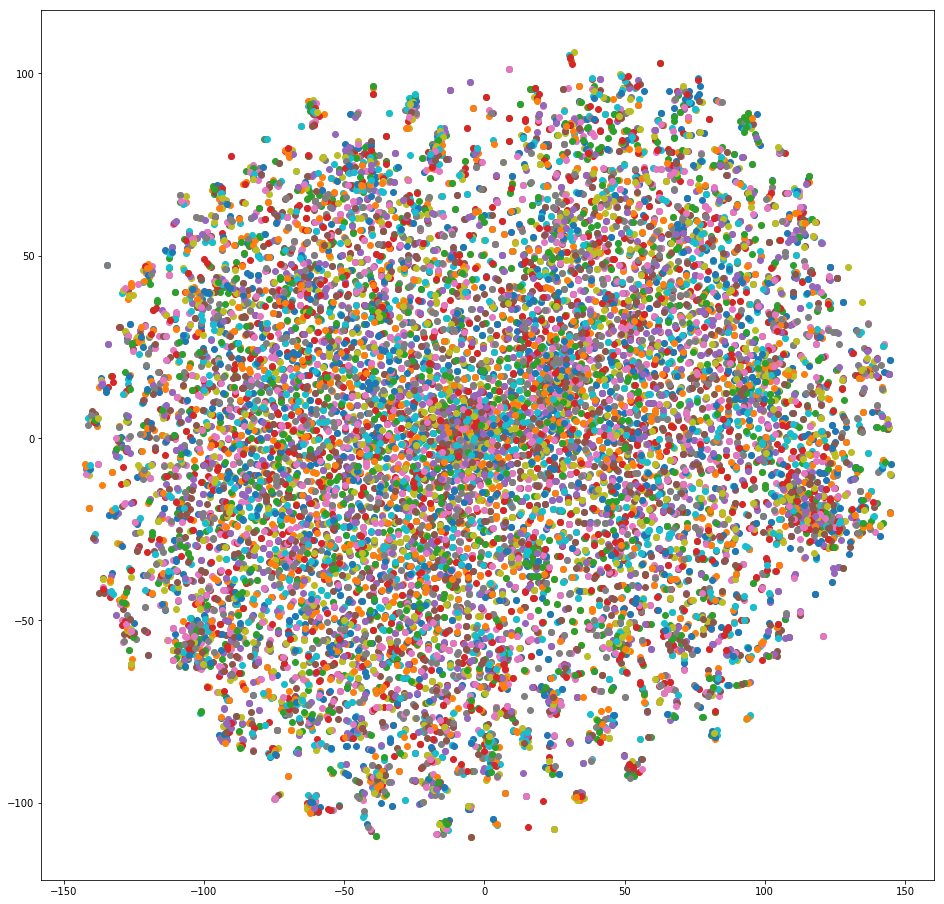

In [80]:
tsne_plot(model)

In [0]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


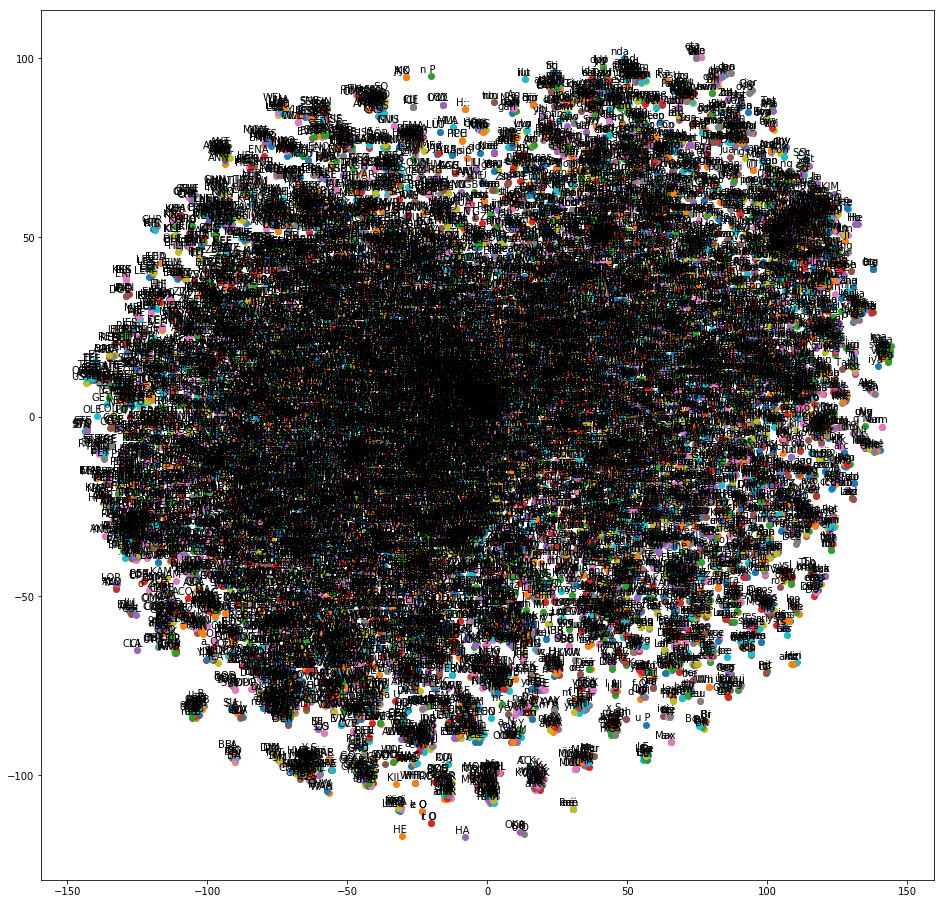

In [55]:
tsne_plot(model)

In [64]:
dictionary[5][6]

' "L'

In [65]:
print(train_set)

[[[8, 45, 38, 57, 0, 14, 16, 22, 25, 14, 12, 27, 27, 16], [17, 79, 51, 40, 38, 47, 0, 0, 9, 48, 43, 52, 38, 47, 0, 20, 70, 19, 19, 12, 25], [27, 34, 53, 58, 34, 47, 34, 0, 29, 12, 16, 21, 9, 12, 25, 14, 8], [32, 48, 54, 47, 40, 5, 8, 41, 0, 14, 16, 19], [21, 42, 44, 48, 45, 34, 48, 52, 0, 18, 8, 18, 19, 8, 20, 8, 21, 8, 18, 16, 26], [18, 42, 51, 44, 0, 23, 8, 19, 20, 12, 25], [21, 34, 37, 38, 59, 41, 37, 34, 0, 19, 16, 28, 9, 16, 20, 22, 29, 8], [12, 45, 38, 47, 34, 0, 25, 22, 20, 8, 21, 22, 29, 8], [26, 34, 47, 40, 5, 12, 54, 47, 0, 22, 15], [19, 54, 36, 42, 34, 0, 20, 22, 25, 16, 10, 22], [17, 48, 52, 38, 49, 41, 0, 9, 8, 25, 27, 15, 12, 19], [9, 38, 55, 38, 51, 45, 38, 58, 0, 17, 48, 58, 0, 30, 15, 16, 27, 13, 16, 12, 19, 11], [14, 38, 46, 46, 34, 0, 9, 12, 8, 11, 26, 30, 22, 25, 27, 15], [27, 48, 47, 38, 0, 15, 8, 28, 14, 12, 21], [29, 45, 34, 52, 53, 42, 35, 48, 51, 0, 18, 22, 21, 12, 10, 21, 32], [14, 34, 45, 42, 47, 34, 0, 33, 32, 9, 16, 21, 8], [8, 47, 34, 53, 48, 45, 42, 0, 20

In [66]:
print(valid_set)

[[[8, 58, 34, 59, 0, 20, 12, 15, 20, 22, 22, 11], [18, 41, 48, 51, 45, 48, 48, 0, 9, 8, 32, 8, 21, 20, 28, 21, 18], [30, 6, 0, 30, 8, 19, 16], [15, 38, 45, 40, 34, 0, 18, 19, 12, 16, 21], [26, 53, 38, 49, 41, 34, 47, 38, 0, 25, 16, 26, 8, 10, 15, 12, 25], [17, 48, 47, 34, 52, 0, 30, 8, 25, 25, 12, 25], [15, 34, 47, 52, 0, 9, 12, 27, 27, 12, 20, 9, 22, 28, 25, 14], [11, 38, 51, 38, 44, 0, 23, 22, 25, 27, 12, 25], [12, 55, 38, 51, 53, 0, 14, 28, 21, 21, 8, 25, 26, 26, 22, 21], [20, 42, 44, 34, 38, 45, 0, 20, 6, 0, 11, 22, 25, 16, 33, 8, 26], [14, 38, 48, 51, 40, 38, 0, 21, 16, 10, 22, 19], [15, 38, 45, 38, 47, 38, 0, 17, 28, 21, 18, 12, 25], [8, 41, 46, 38, 37, 0, 20, 28, 26, 15, 27, 8, 24], [20, 34, 51, 42, 48, 47, 0, 9, 12, 10, 18, 12, 25, 5, 26, 27, 12, 16, 21, 12, 25], [32, 47, 40, 55, 38, 0, 9, 25, 22, 11, 11], [21, 54, 51, 46, 34, 40, 48, 46, 38, 37, 0, 26, 15, 8, 21, 8, 29, 8, 33, 22, 29], [17, 48, 41, 47, 0, 15, 48, 56, 34, 51, 37, 0, 19, 12, 10, 22, 20, 23, 27, 12], [20, 58, 54,

In [95]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 13926


In [96]:
print(model.wv.vocab.keys())

dict_keys(['Ale', 'lex', 'ex ', 'x G', ' GI', 'GIO', 'IOR', 'ORG', 'RGE', 'GET', 'ETT', 'TTI', 'Jör', 'örg', 'rge', 'gen', 'en ', 'n  ', '  B', ' Bo', 'Boj', 'ojs', 'jse', 'sen', 'n M', ' MÖ', 'MÖL', 'ÖLL', 'LLE', 'LER', 'Tat', 'aty', 'tya', 'yan', 'ana', 'na ', 'a V', ' VE', 'VEI', 'EIN', 'INB', 'NBE', 'BER', 'ERG', 'RGA', 'You', 'oun', 'ung', 'ng-', 'g-A', '-Ah', 'Ah ', 'h G', 'GIL', 'Nik', 'iko', 'kol', 'ola', 'lao', 'aos', 'os ', 's K', ' KA', 'KAK', 'AKL', 'KLA', 'LAM', 'AMA', 'MAN', 'ANA', 'NAK', 'AKI', 'KIS', 'Kir', 'irk', 'rk ', 'k P', ' PA', 'PAL', 'ALM', 'LME', 'MER', 'Nad', 'ade', 'dez', 'ezh', 'zhd', 'hda', 'da ', 'a L', ' LI', 'LIU', 'IUB', 'UBI', 'BIM', 'IMO', 'MOV', 'OVA', 'Ele', 'len', 'ena', 'a R', ' RO', 'ROM', 'OMA', 'ANO', 'NOV', 'San', 'ang', 'g-E', '-Eu', 'Eun', 'un ', 'n O', ' OH', 'Luc', 'uci', 'cia', 'ia ', 'a M', ' MO', 'MOR', 'ORI', 'RIC', 'ICO', 'Jos', 'ose', 'sep', 'eph', 'ph ', 'h B', ' BA', 'BAR', 'ART', 'RTH', 'THE', 'HEL', 'Bev', 'eve', 'ver', 'erl', 'r

In [97]:
embedding_vector_dict = {}

for i in model.wv.vocab.keys():
    embedding_vector_dict[i] = model.wv[i]
    
    
print(embedding_vector_dict['lex'])

[-1.5253385   1.635502   -1.4943655   1.79481     2.4347336  -0.6749968
 -3.013662   -3.139934    0.02329779  2.072983   -2.411571   -0.5576554
 -1.7872756  -0.68169075  1.7709658   0.06571046  1.0820638  -0.07405002
  0.8225634  -0.8242763  -0.4207768   0.51713353 -0.17971356 -0.708903
  0.5117143   1.4351571  -1.2723893  -1.0849528   0.49589062 -2.809773
  0.12656593  1.5941477   2.44226    -2.170656   -2.3924236   0.93068445
 -0.14143057 -0.7715826  -0.09976965 -2.9083118   0.57079846  0.29217517
  0.31797993 -1.3077816   4.1380906  -1.325116    2.0807703   1.3827741
 -0.33106482  0.32627854  1.1925982   0.95643836 -0.46128878  0.16758311
  0.6592845  -0.4193409  -1.6727582  -0.42848396  1.7807945   0.40815675
  0.5261999  -1.243079    0.49553752 -0.98097074  1.0885046   0.14275704
  0.31175095  0.51666266  3.4522734   0.11978838  1.0237691  -0.24282524
 -2.4524393   0.25016075  0.78366864 -4.3938107   1.7164967   0.48875055
 -1.7553021   1.4153368   1.3095189   0.2628453  -1.506502

In [98]:
embedding_vector = []

for i in model.wv.vocab.keys():
    embedding_vector.append(model.wv[i])
    
    
print(len(embedding_vector))

13926


In [99]:
embedding_vector = np.array(embedding_vector)
embedding_vector

array([[-2.3037326e+00,  3.3475692e+00,  4.0428603e-01, ...,
         4.2719469e+00, -1.4077020e+00,  1.5133677e+00],
       [-1.5253385e+00,  1.6355020e+00, -1.4943655e+00, ...,
         5.0372043e+00, -5.0598187e+00,  1.1135471e+00],
       [-5.0365281e-01,  1.0004275e+00, -3.8952115e-01, ...,
         7.1606749e-01, -1.1345276e+00,  5.4954964e-01],
       ...,
       [-3.0309972e-01,  2.0914596e-01,  2.2639713e-01, ...,
        -2.9535871e-02, -5.3467974e-02,  2.3983021e-01],
       [-2.3088215e-01,  1.2753822e-01,  1.8869556e-01, ...,
        -2.9969935e-03, -5.9508421e-02,  1.6152121e-01],
       [-1.4197582e-01,  1.3715537e-01,  2.6801340e-02, ...,
         1.0599558e-01,  1.1825152e-01,  4.3437190e-02]], dtype=float32)

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [0]:
embedding_vector_2d = tsne.fit_transform(embedding_vector)

In [74]:
embedding_vector_2d

array([[-69.49027   ,  25.793488  ],
       [-69.837006  ,  25.459488  ],
       [-12.857641  ,  15.647785  ],
       ...,
       [-26.042099  ,  -0.96423036],
       [-25.989643  ,  -0.9687896 ],
       [-32.329937  ,  -9.306016  ]], dtype=float32)

In [75]:
embedding_vector_2d[5][1]

-21.25461

In [100]:
target_ids = list(model.wv.vocab.keys())
print(len(target_ids))

13926


In [77]:
vis_x = []

for i in range(embedding_vector_2d.shape[0]):
    vis_x.append(embedding_vector_2d[i][0])
vis_x = np.array(vis_x)
vis_x

array([-69.49027 , -69.837006, -12.857641, ..., -26.042099, -25.989643,
       -32.329937], dtype=float32)

In [78]:
vis_y = []

for i in range(embedding_vector_2d.shape[0]):
    vis_y.append(embedding_vector_2d[i][1])

vis_y = np.array(vis_y)
vis_y

array([25.793488  , 25.459488  , 15.647785  , ..., -0.96423036,
       -0.9687896 , -9.306016  ], dtype=float32)

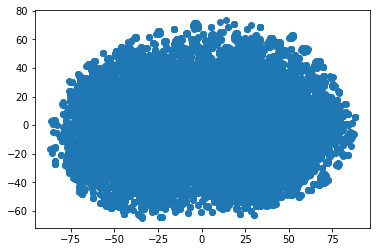

In [50]:
from matplotlib import pyplot as plt

plt.scatter(vis_x, vis_y, label=target_ids)#, cmap=plt.cm.get_cmap("jet", 10))
#plt.colorbar(ticks=range(10))
#plt.clim(-0.5, 9.5)
plt.show()

In [0]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

**LSTM - Trigram**

In [0]:
model_tr = Sequential()
model_tr.add(Embedding(len(word_vectors.vocab), 100, weights=[embedding_vector], trainable=False))
model_tr.add(LSTM(100))
model_tr.add(Dropout(0.0035))
model_tr.add(Dense(1, activation='softmax'))

In [104]:
model_tr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1392600   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 1,473,101
Trainable params: 80,501
Non-trainable params: 1,392,600
_________________________________________________________________


In [0]:
#from keras.utils import to_categorical

model_tr.compile(loss='mean_squared_logarithmic_error',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model_tr.fit(train_set[3], train_set[4], batch_size=64, epochs=15)

Epoch 1/15
10754/10754 [==============================] - 42s 4ms/step - loss: 0.6782 - acc: 0.5860
Epoch 2/15
10754/10754 [==============================] - 40s 4ms/step - loss: 0.5607 - acc: 0.7661
Epoch 3/15
10754/10754 [==============================] - 41s 4ms/step - loss: 0.4130 - acc: 0.8287
Epoch 4/15
10754/10754 [==============================] - 41s 4ms/step - loss: 0.3545 - acc: 0.8543
Epoch 5/15
10754/10754 [==============================] - 42s 4ms/step - loss: 0.3017 - acc: 0.8809
Epoch 6/15
10754/10754 [==============================] - 40s 4ms/step - loss: 0.3060 - acc: 0.8793
Epoch 7/15
10754/10754 [==============================] - 40s 4ms/step - loss: 0.2888 - acc: 0.8913
Epoch 8/15
10754/10754 [==============================] - 40s 4ms/step - loss: 0.2546 - acc: 0.9029
Epoch 9/15
10754/10754 [==============================] - 40s 4ms/step - loss: 0.2330 - acc: 0.9132
Epoch 10/15
10754/10754 [==============================] - 40s 4ms/step - loss: 0.3252 - acc: 0.8645

In [0]:
scores = model_tr.evaluate(test_set[3], test_set[4], verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.64%


**LSTM - Bigram**

In [0]:
model_bi = Sequential()
model_bi.add(Embedding(len(word_vectors.vocab), 100, weights=[embedding_vector], trainable=False))
model_bi.add(LSTM(100))
model_bi.add(Dropout(0.0035))
model_bi.add(Dense(1, activation='softmax'))

In [130]:
model_bi.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 100)         1392600   
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 1,473,101
Trainable params: 80,501
Non-trainable params: 1,392,600
_________________________________________________________________


In [0]:
#from keras.utils import to_categorical

model_bi.compile(loss='mean_squared_logarithmic_error',
              optimizer='adam',
              metrics=['accuracy'])

In [126]:
model_bi.fit(train_set[2], train_set[4], batch_size=64, epochs=15)

Epoch 1/15
10754/10754 [==============================] - 72s 7ms/step - loss: 0.5637 - acc: 0.6796
Epoch 2/15
10754/10754 [==============================] - 70s 7ms/step - loss: 0.2767 - acc: 0.8891
Epoch 3/15
10754/10754 [==============================] - 69s 6ms/step - loss: 0.2010 - acc: 0.9257
Epoch 4/15
10754/10754 [==============================] - 71s 7ms/step - loss: 0.1608 - acc: 0.9423
Epoch 5/15
10754/10754 [==============================] - 69s 6ms/step - loss: 0.1191 - acc: 0.9602
Epoch 6/15
10754/10754 [==============================] - 70s 7ms/step - loss: 0.0789 - acc: 0.9763
Epoch 7/15
10754/10754 [==============================] - 68s 6ms/step - loss: 0.0602 - acc: 0.9826
Epoch 8/15
10754/10754 [==============================] - 69s 6ms/step - loss: 0.0557 - acc: 0.9823
Epoch 9/15
10754/10754 [==============================] - 70s 6ms/step - loss: 0.0346 - acc: 0.9910
Epoch 10/15
10754/10754 [==============================] - 69s 6ms/step - loss: 0.0270 - acc: 0.9935

In [127]:
scores = model_bi.evaluate(test_set[2], test_set[4], verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 84.24%


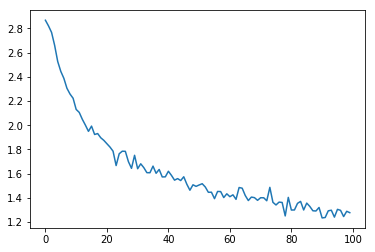

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [18]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


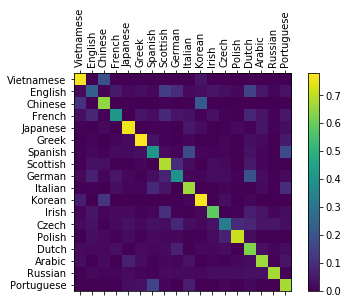

In [32]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()